~ 2 July 2015 ~

In [1]:
% matplotlib inline
import pylab as plt
import numpy as np
import networkx as nx
import pandas as pd
import operator
import os
import re
from glob import glob
import os
os.chdir('/home/jagust/dino/surf/')
import util as util
import modularity as md
from scipy import stats
import operator

In [2]:
# Note: Maybe it would be better to aggregate matrices before thresholding
# Note: Try edge removal
# Note: Try dampening
# Note: Maybe we're looking at the wrong metricsm - think about communicability
# Note: Used individual PiB with individual functional nets

In [4]:
def sort_by_val(d):
    return sorted(d.items(), key = operator.itemgetter(1))

def find_next_node(r, g):
    """ Find the next node to be removed in the simulation
    
    Parameters
    ----------
        r : set of removed nodes
        
    Returns
    -------
        node : next node to be removed
    """
    nodes = g.nodes()
    distance = {}
    for node in nodes:
        if node in r:
            continue
        distance[node] = 0.0
        for removed in r:
            distance[node] += nx.shortest_path_length(g, node, removed, 'weight') 
        sorted_distances = sort_by_val(distance)
    return sorted_distances[0][0]


def run_simulation_comm(fnet, pnet, seed, stop):
    ''' Run lesion simulation
    Parameters
    ----------
    fnet : functional network
    pnet : PiB correlation network
    seed : beginning of simulated lesioning
    stop : terminate simulation after removing stop number of nodes
    
    Returns
    -------
    comms : tracks communicability as nodes are removed
    '''
    # Find partition
    ind = md.newman_partition(fnet, max_div=np.inf).index
    
    # Initial global metrics
    comms = []

    comm = 0.0
    c = nx.communicability(fnet)
    for reg in c:
        comm += sum(c[reg].values())
    comms.append(comm / 2.0)
    
    removed = {seed}
    while len(removed) < stop:
        #print len(removed)
        rem =  find_next_node(removed, pnet)
        removed.add(rem)
        fnet.remove_edges_from(fnet.edges(rem))
        
        comm = 0.0
        c = nx.communicability(fnet)
        for reg in c:
            comm += sum(c[reg].values())
        comms.append(comm / 2.0)
    
    return comms

In [5]:
# Import Matrices
fmat = np.load('/home/jagust/dino/surf/thr_func_group_mat.npy')
fmat_neg = np.load('/home/jagust/dino/surf/thr_neg_func_mat.npy')
fmat_pos = np.load('/home/jagust/dino/surf/thr_pos_func_mat.npy')
pibmat = np.load('/home/jagust/dino/surf/pib_mat.npy')

pibmatpos = np.load('/home/jagust/dino/surf/neg_pib_mat.npy')
pibmatneg = np.load('/home/jagust/dino/surf/pos_pib_mat.npy')

thrpibmat, cost = util.threshold_adjacency_matrix(pibmat, cost = 0.20)
thrpibnet = nx.Graph(thrpibmat)

In [6]:
# Functional Network Formation
fnet = nx.from_numpy_matrix(fmat)
fnet_neg = nx.from_numpy_matrix(fmat_neg)
fnet_pos = nx.from_numpy_matrix(fmat_pos)

In [7]:
# PiB Netowrk Formation
pibnet = nx.from_numpy_matrix(pibmat)

In [ ]:
# Modify the PiB Correlation Matrix in order to be able to use nx.shortest_path_length
invpibmat = -1.0 * pibmat + 1.0
invpibnet = nx.from_numpy_matrix(invpibmat)
inp_fnet_neg, inp_fnet_pos, inp_pnet = fnet_neg.copy(), fnet_pos.copy(), invpibnet.copy()

seed = 55

# Run Simulation
print "Starting E4 Positive Simulation"
commpos = run_simulation_comm(inp_fnet_pos, inp_pnet, seed, 60)
print "Starting E4 Negative Simulation"
commneg = run_simulation_comm(inp_fnet_neg, inp_pnet, seed, 60) 

# Plot Communicabilities
fig = plt.figure()
ax = fig.add_subplot(111)


ax.scatter(range(len(commpos)), commpos, c = 'b')
ax.scatter(range(len(commneg)), commneg, c = 'r')

plt.xlabel('# Nodes Removed')
plt.ylabel('Communicability')

# plt.xlim(0, 60)
# plt.ylim(0, 1e6)

In [8]:
globstr = "/home/jagust/graph/data/mri1.5/analysis/roi_networks/desikan/adjmat_gsr/*"
mat_paths = sorted(glob(globstr))

In [9]:
mat_paths[200:len(mat_paths)]

['/home/jagust/graph/data/mri1.5/analysis/roi_networks/desikan/adjmat_gsr/B11-255_2014-04-17_adjmat.npy',
 '/home/jagust/graph/data/mri1.5/analysis/roi_networks/desikan/adjmat_gsr/B11-256_2011-05-31_adjmat.npy',
 '/home/jagust/graph/data/mri1.5/analysis/roi_networks/desikan/adjmat_gsr/B11-257_2011-09-19_adjmat.npy',
 '/home/jagust/graph/data/mri1.5/analysis/roi_networks/desikan/adjmat_gsr/B12-202_2012-03-12_adjmat.npy',
 '/home/jagust/graph/data/mri1.5/analysis/roi_networks/desikan/adjmat_gsr/B12-202_2012-10-29_adjmat.npy',
 '/home/jagust/graph/data/mri1.5/analysis/roi_networks/desikan/adjmat_gsr/B12-202_2014-09-08_adjmat.npy',
 '/home/jagust/graph/data/mri1.5/analysis/roi_networks/desikan/adjmat_gsr/B12-203_2012-04-09_adjmat.npy',
 '/home/jagust/graph/data/mri1.5/analysis/roi_networks/desikan/adjmat_gsr/B12-203_2012-09-25_adjmat.npy',
 '/home/jagust/graph/data/mri1.5/analysis/roi_networks/desikan/adjmat_gsr/B12-203_2014-03-13_adjmat.npy',
 '/home/jagust/graph/data/mri1.5/analysis/roi_

Subject: 1 out of: 342
Subject: 2 out of: 342
Subject: 3 out of: 342
Subject: 4 out of: 342
Subject: 5 out of: 342
Subject: 6 out of: 342
Subject: 7 out of: 342
Subject: 8 out of: 342
Subject: 9 out of: 342
Subject: 10 out of: 342


ValueError: NAN found in adjacency matrix, this will causeimproper behavior in sorting and improper results, please remove all nan 

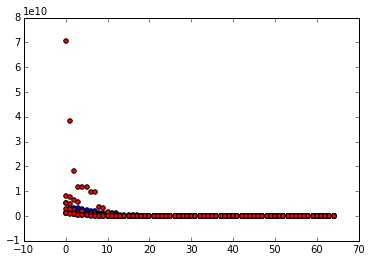

In [15]:
fig = plt.figure()
ax = fig.add_subplot(111)
sub = 1
seed = 55
stop = 65
for p in mat_paths[2:]:
# try:
    print "Subject: " + str(sub) + " out of: " + str(len(mat_paths))
    sub += 1
    mat = np.load(p)
    thr_func_mat, c = util.threshold_adjacency_matrix(mat, cost = 0.20)
    ss = get_subsess(p)
    if type(is_geno_pos(ss)) == str:
        print "No geno data"
        continue
    elif is_geno_pos(ss):
        invpibmatpos = -1.0 * pibmatpos + 1.0
        invpibnetpos = nx.from_numpy_matrix(invpibmatpos)
        inp_pnet_pos = invpibnetpos.copy()

        # Run Simulation
        comm = run_simulation_comm(nx.Graph(thr_func_mat), inp_pnet_pos, seed, stop)
        comm_copy = np.array(comm)
        np.save('/home/jagust/dino/surf/simulation_trials/individuals/communicability/%s.npy' % (ss), comm_copy)

        # Plot Communicability
        ax.scatter(range(len(comm)), comm, c = 'b')
    else:
        invpibmatneg = -1.0 * pibmatneg + 1.0
        invpibnetneg = nx.from_numpy_matrix(invpibmatneg)
        inp_pnet_neg = invpibnetneg.copy()

        # Run Simulation and save data
        comm = run_simulation_comm(nx.Graph(thr_func_mat), inp_pnet_pos, seed, stop)
        comm_copy = np.array(comm)
        np.save('/home/jagust/dino/surf/simulation_trials/individuals/communicability/%s.npy' % (ss), comm_copy)

        # Plot Comm
        ax.scatter(range(len(comm)), comm, c = 'r')
# except:
#     print "Problem: " + p

plt.ylabel('Communicability')
plt.xlabel('# Nodes Removed')

In [11]:
master_subject_path = "/home/jagust/dino/graph/data/mri1.5/rest/master_subject_summary.xlsx"
subject_summary = pd.ExcelFile(master_subject_path).parse("Sheet1")

def get_subsess(path):
    direc = "/home/jagust/graph/data/mri1.5/analysis/roi_networks/desikan/adjmat_gsr/"
    ind1 = len(direc)
    ind2 = ind1 + 18
    return path[ind1:ind2]
def is_geno_pos(ss):
    if len(ss) > 7:
        num_copies = subject_summary[subject_summary.Subsess == ss].values[0][6]
        if num_copies not in [0, 1, 2]:
            print "No genotype data: " + find_id(ss)
            return'x'
        else:
            return num_copies > 0.0
    else:
        num_copies = subject_summary[subject_summary.LBLID == ss].values[0][6]
        if num_copies not in [0, 1, 2]:
            print "No genotype data: " + find_id(ss)
            return
        else:
            return num_copies > 0.0